# SUSARA THENUWARA 179418B


# Instructions

To run each version restart runtime

         Runtime -> Restart Runtime



Then run **Data Download Cell** and **Data Loader Cell** respectively.

Finally run the cell under the corresponding version


*For every version test accuracy is plotted and observations are given*


# Analysis 


1.   Multi Layer Perceptron basic architecture
2.   With droputs
3.   L2 Regularization without dropouts
4.   L2 Regularization with dropouts
5.   Batch Normalization
6.   Layer Normalization







**Data Download**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pickle
import numpy as np
import os
import tarfile
import zipfile
import sys

try: 
	from urllib.request import urlretrieve 
except ImportError:
	from urllib import urlretrieve 

def _download_progress(count, block_size, total_size):
    percent_complete = float(count * block_size) / total_size
    msg = "\r- Data download progress: {0:.1%}".format(percent_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_and_extract():
	_dir = "./"
	data_dir = "./cifar-10-batches-py"

	if os.path.exists(data_dir):
		print("CIFAR-10 data already downloaded.")
		return
	else:
		url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
		filename = url.split('/')[-1]
		file_path = os.path.join(_dir, filename)
		zip_cifar_10 = file_path
		file_path, _ = urlretrieve(url=url, filename=file_path, reporthook=_download_progress)

		print()
		print("Download finished. Extracting files in " + data_dir + ".")
		if file_path.endswith(".zip"):
			zipfile.ZipFile(file=file_path, mode="r").extractall(_dir)
		elif file_path.endswith((".tar.gz", ".tgz")):
			tarfile.open(name=file_path, mode="r:gz").extractall(_dir)
		print("Done.")

		os.remove(zip_cifar_10)


**Data Loader**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

def unpickle( file ):
	try: 
		import cPickle
		fo = open(file, 'rb')
		dict = cPickle.load(fo)
	except ImportError:
		import _pickle as cPickle
		fo = open(file, 'rb')
		dict = cPickle.load(fo, encoding='latin-1')

	fo.close()
	return dict

def one_hot_vec(label):
	vec = np.zeros(10)
	vec[label] = 1
	return vec

def whiten_data(features):
	features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
	return features

def load_data(ratio = 0.8):
	for _ in range(5):
		d = unpickle( 'cifar-10-batches-py/data_batch_' + str(_+1) )

		if(_ == 0):
			_x = d['data']
			_y = d['labels']
		else:
			_x = np.vstack((_x, d['data']))
			_y = np.concatenate((_y, d['labels']), axis=0)

	d = unpickle('cifar-10-batches-py/test_batch')
	_x = np.vstack((_x, d['data']))
	_y = np.concatenate((_y, d['labels']), axis=0)
	
	_x = whiten_data(_x)
	_y = np.array(list(map(one_hot_vec, _y)))

	index = int(ratio * len(_x)) # Split index
	x_train = _x[0:index, :]
	y_train = _y[0:index]
	x_test = _x[index:,:]
	y_test = _y[index:]

	print("Data Split: ", ratio)
	print("Train => x:", x_train.shape, " y:", len(y_train))
	print("Test  => x:", x_test.shape, " y:", len(y_test))

	return [x_train, y_train, x_test, y_test]

class DataLoader():
	def __init__(self):
		download_and_extract()
		self.x_train, self.y_train, self.x_test, self.y_test = load_data()

	def next_batch(self, batch_size):
		length = self.x_train.shape[0]
		indices = np.random.randint(0, length, batch_size) # Grab batch_size values randomly
		return [self.x_train[indices], self.y_train[indices]]

**MLP Implementation**

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cifar = DataLoader()

learning_rate = 0.0001
num_steps = 10000
batch_size = 128
display_step = 100
_WIDTH = 32; _HEIGHT = 32; _CHANNELS = 3 
NUM_INPUTS = _WIDTH * _HEIGHT * _CHANNELS 
NUM_OUTPUTS = 10
NUM_H1 = 512
NUM_H2 = 256

X = tf.placeholder(tf.float32, [None, NUM_INPUTS])
Y = tf.placeholder(tf.float32, [None, NUM_OUTPUTS])

he_init = tf.contrib.layers.variance_scaling_initializer()  
fc1 = tf.layers.dense(X, NUM_H1, activation=tf.nn.relu, kernel_initializer=he_init, name='fc1') 
fc2 = tf.layers.dense(fc1, NUM_H2, activation=tf.nn.relu, kernel_initializer=he_init, name='fc2') 
logits = tf.layers.dense(fc2, NUM_OUTPUTS, name='logits')
prediction = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

_step = []
_acc = []
for step in range(num_steps):
    batch_xs, batch_ys = cifar.next_batch(batch_size)
    sess.run( trainer, feed_dict={X: batch_xs, Y: batch_ys} )

    if(step % display_step == 0):
      acc = sess.run(accuracy, feed_dict={X: cifar.x_test, Y: cifar.y_test }) 
      _step.append(step)
      _acc.append(acc)

      print("Step: " + str(step) + " Test Accuracy: " + str(acc)) 
      


- Data download progress: 100.0%
Download finished. Extracting files in ./cifar-10-batches-py.
Done.
Data Split:  0.8
Train => x: (48000, 3072)  y: 48000
Test  => x: (12000, 3072)  y: 12000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step: 0 Test Accuracy: 0.1195
Step: 100 Test Accuracy: 0.39208335
Step: 200 Test Accuracy: 0.4255
Step: 300 Test Accuracy: 0.

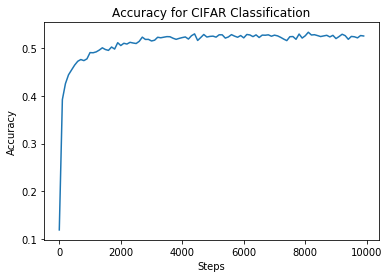

In [5]:
plt.plot(_step, _acc, label="test accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy for CIFAR Classification")
plt.show()

**Observations**

After 2000 iterations testing error reaches to around 0.5. This happens because of the network being overfitted to the network due to the large number of features extracted. In order to improve accuracy in such cases there are several attempts likewise demonstrated in following sections separately.

**Version 1 - With Dropouts**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cifar = DataLoader()

learning_rate = 0.0001
num_steps = 10000
batch_size = 128
display_step = 100
_WIDTH = 32; _HEIGHT = 32; _CHANNELS = 3 
NUM_INPUTS = _WIDTH * _HEIGHT * _CHANNELS 
NUM_OUTPUTS = 10
NUM_H1 = 512
NUM_H2 = 256

X = tf.placeholder(tf.float32, [None, NUM_INPUTS]) 
Y = tf.placeholder(tf.float32, [None, NUM_OUTPUTS])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
is_training = tf.placeholder(tf.bool, shape=())

he_init = tf.contrib.layers.variance_scaling_initializer() 
fc1 = tf.layers.dense(X, NUM_H1, activation=tf.nn.relu, kernel_initializer=he_init, name='fc1')  
fc2 = tf.layers.dense(fc1, NUM_H2, activation=tf.nn.relu, kernel_initializer=he_init, name='fc2')

# Apply Dropout (if is_training is False, dropout is not applied)
fc2 = tf.layers.dropout(fc2, rate=keep_prob, training=is_training)

logits = tf.layers.dense(fc2, NUM_OUTPUTS, name='logits')
prediction = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

_step = []
_acc = []

for step in range(num_steps):
    batch_xs, batch_ys = cifar.next_batch(batch_size)
    sess.run( trainer, feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.7,is_training: True } )

    if(step % display_step == 0):
      acc = sess.run(accuracy, feed_dict={X: cifar.x_test, Y: cifar.y_test,  keep_prob:1,is_training: False }) 
      _step.append(step)
      _acc.append(acc)

      print("Step: " + str(step) + " Test Accuracy: " + str(acc)) 

CIFAR-10 data already downloaded.
Data Split:  0.8
Train => x: (48000, 3072)  y: 48000
Test  => x: (12000, 3072)  y: 12000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step: 0 Test Accuracy: 0.10366666
Step: 100 Test Accuracy: 0.348
Step: 200 Test Accuracy: 0.37416667
Step: 300 Test Accuracy: 0.39608333
Step: 400 Test Accuracy: 0.40808332
Step: 500 Test Accuracy: 0.41483334
Step: 600 Test Accuracy: 0.42258334
Step: 700 Test Accuracy: 0.42916667
Step: 800 Test Accuracy: 0.4315
Step: 900 Test Accuracy: 0.43758333
Step: 1000 Test Accuracy: 0.44575
Step: 1100 Test Accuracy: 0.4495
Step: 1200 Test Accuracy: 0.45375
Step: 1300 Test Accuracy: 0.45658332
Step: 1400 Test Accuracy: 0.46025
Step: 1500 Test Accuracy: 0.45891666
Step: 1600 Test Accuracy: 0.46908334
Step: 1700 Test Accuracy: 0.47158334
Step: 1800 Test Accuracy: 0.46808332
Step: 1900 Test A

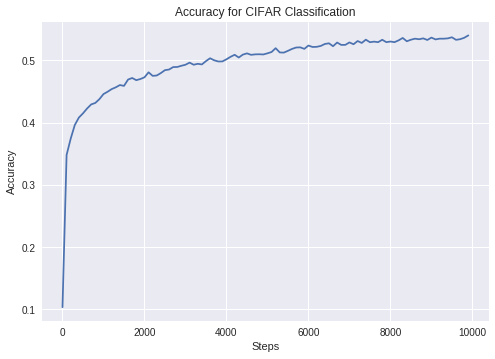

In [0]:
plt.plot(_step, _acc, label="test accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy for CIFAR Classification - With Dropouts")
plt.show()

**Observations**

With dropouts it seems to increase the test accuracy over time. This is because we are dropping the final hidden layer neurons by comparing keep_probability and it eventually make the network to generalize well and increase the accuracy.

**Version 2 - L2 Reqularization without Dropouts**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cifar = DataLoader()

learning_rate = 0.0001
num_steps = 10000
batch_size = 128
display_step = 100
_WIDTH = 32; _HEIGHT = 32; _CHANNELS = 3 
NUM_INPUTS = _WIDTH * _HEIGHT * _CHANNELS 
NUM_OUTPUTS = 10
NUM_H1 = 512
NUM_H2 = 256

X = tf.placeholder(tf.float32, [None, NUM_INPUTS]) 
Y = tf.placeholder(tf.float32, [None, NUM_OUTPUTS]) 

he_init = tf.contrib.layers.variance_scaling_initializer()
fc1 = tf.layers.dense(X, NUM_H1, activation=tf.nn.relu, kernel_initializer=he_init, name='fc1') 
fc2 = tf.layers.dense(fc1, NUM_H2, activation=tf.nn.relu, kernel_initializer=he_init, name='fc2')
logits = tf.layers.dense(fc2, NUM_OUTPUTS, name='logits') 
prediction = tf.nn.softmax(logits)

with tf.variable_scope("fc2", reuse=True):
    fc2_weight = tf.get_variable("kernel")
    
with tf.variable_scope("logits", reuse=True):
    logits_weight = tf.get_variable("kernel")
    
loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))+
    0.01*tf.nn.l2_loss(fc2_weight)+
    0.01*tf.nn.l2_loss(logits_weight))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

_step = []
_acc = []
for step in range(num_steps):
    batch_xs, batch_ys = cifar.next_batch(batch_size)
    sess.run( trainer, feed_dict={X: batch_xs, Y: batch_ys} )

    if(step % display_step == 0):
      acc = sess.run(accuracy, feed_dict={X: cifar.x_test, Y: cifar.y_test }) 
      _step.append(step)
      _acc.append(acc)

      print("Step: " + str(step) + " Test Accuracy: " + str(acc)) 
      


CIFAR-10 data already downloaded.
Data Split:  0.8
Train => x: (48000, 3072)  y: 48000
Test  => x: (12000, 3072)  y: 12000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step: 0 Test Accuracy: 0.1465
Step: 100 Test Accuracy: 0.3965
Step: 200 Test Accuracy: 0.42441666
Step: 300 Test Accuracy: 0.44016665
Step: 400 Test Accuracy: 0.45541668
Step: 500 Test Accuracy: 0.45516667
Step: 600 Test Accuracy: 0.47241667
Step: 700 Test Accuracy: 0.47533333
Step: 800 Test Accuracy: 0.47583333
Step: 900 Test Accuracy: 0.48841667
Step: 1000 Test Accuracy: 0.48658332
Step: 1100 Test Accuracy: 0.48883334
Step: 1200 Test Accuracy: 0.50058335
Step: 1300 Test Accuracy: 0.5006667
Step: 1400 Test Accuracy: 0.5035833
Step: 1500 Test Accuracy: 0.5075833
Step: 1600 Test Accuracy: 0.50525
Step: 1700 Test Accuracy: 0.519
Step: 1800 Test Accuracy: 0.50725
Step: 1900 Test A

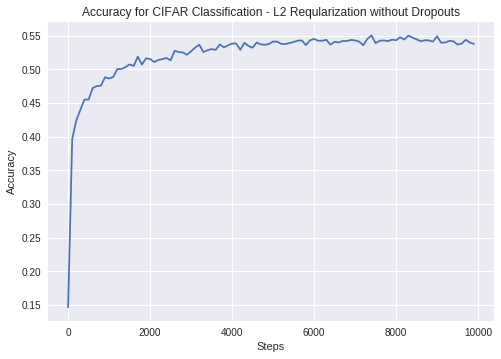

In [0]:
plt.plot(_step, _acc, label="test accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy for CIFAR Classification - L2 Reqularization without Dropouts")
plt.show()

**Observations**

By adding L2 regularization it obtained higer accuracy over testing batches, i.e. 0.55. This is because its adding a upper limit to the weight update an keep inside the balancing interval to memorize the features rather than making it to memorize noisy features wihtout keeping a limit

**Version 3 - L2 Reqularization with Dropouts**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cifar = DataLoader()

learning_rate = 0.0001
num_steps = 10000
batch_size = 128
display_step = 100
_WIDTH = 32; _HEIGHT = 32; _CHANNELS = 3 
NUM_INPUTS = _WIDTH * _HEIGHT * _CHANNELS 
NUM_OUTPUTS = 10
NUM_H1 = 512
NUM_H2 = 256

X = tf.placeholder(tf.float32, [None, NUM_INPUTS])  
Y = tf.placeholder(tf.float32, [None, NUM_OUTPUTS]) 

he_init = tf.contrib.layers.variance_scaling_initializer() 
fc1 = tf.layers.dense(X, NUM_H1, activation=tf.nn.relu, kernel_initializer=he_init, name='fc1')  
fc2 = tf.layers.dense(fc1, NUM_H2, activation=tf.nn.relu, kernel_initializer=he_init, name='fc2') 
logits = tf.layers.dense(fc2, NUM_OUTPUTS, name='logits')
prediction = tf.nn.softmax(logits)

with tf.variable_scope("fc2", reuse=True):
    fc2_weight = tf.get_variable("kernel") 
    
with tf.variable_scope("logits", reuse=True):
    logits_weight = tf.get_variable("kernel") 
    
loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))+
    0.01*tf.nn.l2_loss(fc2_weight)+
    0.01*tf.nn.l2_loss(logits_weight))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

_step = []
_acc = []
for step in range(num_steps):
    batch_xs, batch_ys = cifar.next_batch(batch_size)
    sess.run( trainer, feed_dict={X: batch_xs, Y: batch_ys} )

    if(step % display_step == 0):
      acc = sess.run(accuracy, feed_dict={X: cifar.x_test, Y: cifar.y_test }) 
      _step.append(step)
      _acc.append(acc)

      print("Step: " + str(step) + " Test Accuracy: " + str(acc)) 
      


CIFAR-10 data already downloaded.
Data Split:  0.8
Train => x: (48000, 3072)  y: 48000
Test  => x: (12000, 3072)  y: 12000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step: 0 Test Accuracy: 0.10733333
Step: 100 Test Accuracy: 0.38816667
Step: 200 Test Accuracy: 0.42391667
Step: 300 Test Accuracy: 0.4405
Step: 400 Test Accuracy: 0.45558333
Step: 500 Test Accuracy: 0.46166667
Step: 600 Test Accuracy: 0.47025
Step: 700 Test Accuracy: 0.47508332
Step: 800 Test Accuracy: 0.482
Step: 900 Test Accuracy: 0.49025
Step: 1000 Test Accuracy: 0.4905
Step: 1100 Test Accuracy: 0.48966667
Step: 1200 Test Accuracy: 0.50208336
Step: 1300 Test Accuracy: 0.49908334
Step: 1400 Test Accuracy: 0.5000833
Step: 1500 Test Accuracy: 0.5096667
Step: 1600 Test Accuracy: 0.5060833
Step: 1700 Test Accuracy: 0.51416665
Step: 1800 Test Accuracy: 0.5125833
Step: 1900 Test Ac

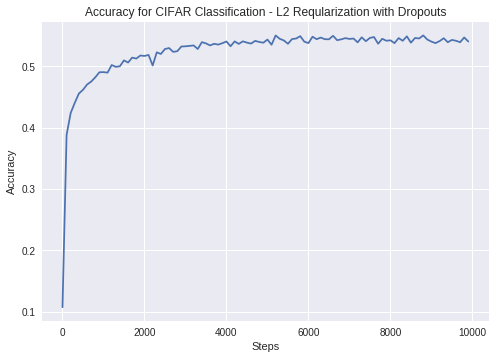

In [0]:
plt.plot(_step, _acc, label="test accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy for CIFAR Classification - L2 Reqularization with Dropouts")
plt.show()

**Observations**

Although it is expected to have a higher accuracy (atleast than 0.55 with L2 regularization) surprisingly here we got rather a same accuracy as with dropouts. This can be due to the number of neurons per layer and having the less number of layers.

**Version 4 - Batch Normalization**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cifar = DataLoader()

learning_rate = 0.0001
num_steps = 10000
batch_size = 128
display_step = 100
_WIDTH = 32; _HEIGHT = 32; _CHANNELS = 3 
NUM_INPUTS = _WIDTH * _HEIGHT * _CHANNELS 
NUM_OUTPUTS = 10
NUM_H1 = 512
NUM_H2 = 256

X = tf.placeholder(tf.float32, [None, NUM_INPUTS])  
Y = tf.placeholder(tf.float32, [None, NUM_OUTPUTS])
is_training = tf.placeholder(tf.bool,shape=[])

he_init = tf.contrib.layers.variance_scaling_initializer() 
fc1 = tf.layers.dense(X, NUM_H1, activation=tf.nn.relu, kernel_initializer=he_init, name='fc1') 
conv1_bn = tf.layers.batch_normalization(
      inputs=fc1,
      axis=-1,
      momentum=0.9,
      epsilon=0.001,
      center=True,
      scale=True,
      training = is_training,
      name='conv1_bn'
  )
fc2 = tf.layers.dense(conv1_bn, NUM_H2, activation=tf.nn.relu, kernel_initializer=he_init, name='fc2') 
conv2_bn = tf.layers.batch_normalization(
      inputs=fc2,
      axis=-1,
      momentum=0.9,
      epsilon=0.001,
      center=True,
      scale=True,
      training = is_training,
      name='conv2_bn'
  )
logits = tf.layers.dense(conv2_bn, NUM_OUTPUTS, name='logits') 
prediction = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

_step = []
_acc = []
for step in range(num_steps):
    batch_xs, batch_ys = cifar.next_batch(batch_size)
    sess.run( trainer, feed_dict={X: batch_xs, Y: batch_ys, is_training:True} )

    if(step % display_step == 0):
      acc = sess.run(accuracy, feed_dict={X: cifar.x_test, Y: cifar.y_test, is_training:False }) 
      _step.append(step)
      _acc.append(acc)

      print("Step: " + str(step) + " Test Accuracy: " + str(acc)) 
      


CIFAR-10 data already downloaded.
Data Split:  0.8
Train => x: (48000, 3072)  y: 48000
Test  => x: (12000, 3072)  y: 12000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step: 0 Test Accuracy: 0.10033333
Step: 100 Test Accuracy: 0.31033334
Step: 200 Test Accuracy: 0.31758332
Step: 300 Test Accuracy: 0.34675
Step: 400 Test Accuracy: 0.34766668
Step: 500 Test Accuracy: 0.35633335
Step: 600 Test Accuracy: 0.3735
Step: 700 Test Accuracy: 0.36983332
Step: 800 Test Accuracy: 0.36033332
Step: 900 Test Accuracy: 0.38125
Step: 1000 Test Accuracy: 0.37808332
Step: 1100 Test Accuracy: 0.39575
Step: 1200 Test Accuracy: 0.37591666
Step: 1300 Test Accuracy: 0.387
Step: 1400 Test Accuracy: 0.39033332
Step: 1500 Test Accuracy: 0.39866668
Step: 1600 Test Accuracy: 0.39216667
Step: 1700 Test Accuracy: 0.39825
Step: 1800 Test Accuracy: 0.39783335
Step: 1900 Test 

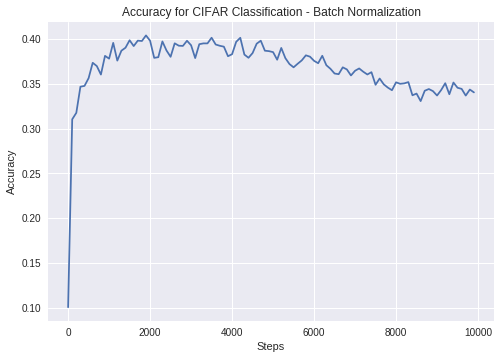

In [0]:
\plt.plot(_step, _acc, label="test accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy for CIFAR Classification - Batch Normalization")
plt.show()

**Observations**

With batch normalization, it decreased the test accuracy over the epochs.

**Version 5 - Layer Normalization**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

cifar = DataLoader()

learning_rate = 0.0001
num_steps = 10000
batch_size = 128
display_step = 100
_WIDTH = 32; _HEIGHT = 32; _CHANNELS = 3 
NUM_INPUTS = _WIDTH * _HEIGHT * _CHANNELS 
NUM_OUTPUTS = 10
NUM_H1 = 512
NUM_H2 = 256

X = tf.placeholder(tf.float32, [None, NUM_INPUTS])  
Y = tf.placeholder(tf.float32, [None, NUM_OUTPUTS]) 

he_init = tf.contrib.layers.variance_scaling_initializer()
fc1 = tf.layers.dense(X, NUM_H1, activation=tf.nn.relu, kernel_initializer=he_init, name='fc1') 
fc1_ln= tf.contrib.layers.layer_norm(fc1)
fc2 = tf.layers.dense(fc1_ln, NUM_H2, activation=tf.nn.relu, kernel_initializer=he_init, name='fc2')
fc2_ln= tf.contrib.layers.layer_norm(fc2)
logits = tf.layers.dense(fc2_ln, NUM_OUTPUTS, name='logits') 
prediction = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

_step = []
_acc = []
for step in range(num_steps):
    batch_xs, batch_ys = cifar.next_batch(batch_size)
    sess.run( trainer, feed_dict={X: batch_xs, Y: batch_ys} )

    if(step % display_step == 0):
      acc = sess.run(accuracy, feed_dict={X: cifar.x_test, Y: cifar.y_test }) 
      _step.append(step)
      _acc.append(acc)

      print("Step: " + str(step) + " Test Accuracy: " + str(acc)) 
      


CIFAR-10 data already downloaded.
Data Split:  0.8
Train => x: (48000, 3072)  y: 48000
Test  => x: (12000, 3072)  y: 12000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step: 0 Test Accuracy: 0.13691667
Step: 100 Test Accuracy: 0.38316667
Step: 200 Test Accuracy: 0.41141668
Step: 300 Test Accuracy: 0.43083334
Step: 400 Test Accuracy: 0.43916667
Step: 500 Test Accuracy: 0.458
Step: 600 Test Accuracy: 0.4635
Step: 700 Test Accuracy: 0.471
Step: 800 Test Accuracy: 0.473
Step: 900 Test Accuracy: 0.47925
Step: 1000 Test Accuracy: 0.48066667
Step: 1100 Test Accuracy: 0.48441666
Step: 1200 Test Accuracy: 0.49158335
Step: 1300 Test Accuracy: 0.49425
Step: 1400 Test Accuracy: 0.49758333
Step: 1500 Test Accuracy: 0.49833333
Step: 1600 Test Accuracy: 0.50333333
Step: 1700 Test Accuracy: 0.5081667
Step: 1800 Test Accuracy: 0.5058333
Step: 1900 Test Accura

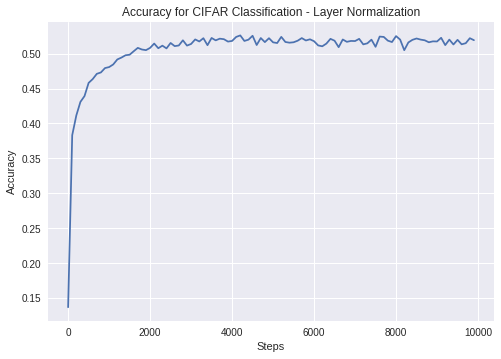

In [0]:
plt.plot(_step, _acc, label="test accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy for CIFAR Classification - Layer Normalization")
plt.show()